In [1]:
# --- 1. Importazioni e Setup ---
import json
import random
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np # Aggiunto per caricare i file .npy
import matplotlib.cm as cm
from scipy.stats import binned_statistic_2d
from collections import Counter, defaultdict
import itertools
import matplotlib.cm as cm # Per i colori
import traceback # Per debug


In [2]:

# --- Configurazioni ---
METADATA_JSON_PATH = '/leonardo_work/INA24_C5B09/radio-data-curation-ssl/outputs/cutouts/cutouts-strategy_sliding_window-overlap_05-size_256_30d67552/info.json' # <<< MODIFICA QUESTO
ANNOTATIONS_CSV_PATH = 'annotazioni_immagini.csv' # <<< File dove salvare le annotazioni
IMAGE_BASE_DIR = '/leonardo_work/INA24_C5B09/radio-data-curation-ssl' # <<< MODIFICA: Directory base se image_path è relativo

USE_SUBSET = True  # Imposta a True per usare il sottocampione, False per il dataset completo
SUBSET_INDEX_NPY_PATH = '/leonardo_work/INA24_C5B09/radio-data-curation-ssl/outputs/clusters/clusters-n_levels_3-level0_5000-level1_500-level2_50_21897cd5/subsampled_indices-target_size_25000_8faa85b9.npy' 

PREDEFINED_CATEGORIES = ['sparse', 'populated', 'small-galaxy', 'diffuse', 'artefact', 'point-like', 'full-resolved', 'little-resolved'] # Esempio di categorie predefinite
UMAP_EMBEDDING_NPY_PATH = "/leonardo_work/INA24_C5B09/radio-data-curation-ssl/outputs/clusters/clusters-n_levels_3-level0_5000-level1_500-level2_50_21897cd5/umap_visualization_609ede9f9895441ebbf4f439622296d1/umap_embedding.npy"

N_BINS_UMAP = 15

# --- Variabili Globali (o stato della cella) ---
metadata = [] # Sarà una lista di dizionari
current_image_data = None
current_image_array = None # Per memorizzare l'array caricato
# Assicurati che la colonna chiave sia 'file_path'
annotations_df = pd.DataFrame(columns=['file_path', 'categories'])
current_metadata_index = None # <<< NUOVO: Indice dell'immagine corrente nella lista 'metadata'
umap_coords = None            # <<< NUOVO: Coordinate UMAP caricate
subset_indices_array = None # <<< NUOVO: Array degli indici del subset (se USE_SUBSET=True)
filepath_to_index_map = {}   # Mappa file_path -> indice nella lista 'metadata'
labeled_indices = set()      # Set degli indici (in 'metadata') già etichettati
unlabeled_indices = []       # Lista degli indici (in 'metadata') non etichettati
sampling_weights = None      # Array numpy con i pesi per il campionamento degli indici non etichettati
grid_x_edges = None
grid_y_edges = None
grid_labeled_counts = None # Conteggio etichettati per cella
grid_total_counts = None   # Conteggio totale per cella
cell_to_indices_map = defaultdict(list) # <<< NUOVO: Mappa (bx, by) -> lista indici in quella cella
unlabeled_indices_set = set()         # <<< NUOVO: Set per check rapidi sugli indici non etichettati



In [3]:
# --- 2. Caricamento Dati ---
print("Caricamento metadati...")
metadata = []
umap_coords = None  # Inizializza UMAP a None
subset_indices_array = None # Per riferimento se necessario

try:
    # Carica SEMPRE il DataFrame completo dal JSON
    metadata_df_full = pd.read_json(METADATA_JSON_PATH, orient='index')
    print(f"Caricato DataFrame completo con {len(metadata_df_full)} record.")
    full_metadata_list = metadata_df_full.to_dict(orient='records')

    # --- Logica per usare dataset completo o sottocampione ---
    if USE_SUBSET:
        print(f"Modalità Sottocampione: Caricamento indici da {SUBSET_INDEX_NPY_PATH}")
        try:
            # Carica gli indici ORIGINALI del subset
            subset_indices_original = np.load(SUBSET_INDEX_NPY_PATH)
            print(f"Caricati {len(subset_indices_original)} indici dal file NumPy.")

            # --- Validazione Indici e Creazione Subset Metadata ---
            max_index = len(full_metadata_list) - 1
            valid_indices_original = [] # Indici ORIGINALI validi
            invalid_count = 0
            for i in subset_indices_original:
                try:
                    idx = int(i)
                    if 0 <= idx <= max_index:
                        valid_indices_original.append(idx)
                    else:
                        invalid_count += 1
                except (ValueError, TypeError):
                    invalid_count += 1

            if invalid_count > 0: print(f"ATTENZIONE: {invalid_count} indici NumPy invalidi ignorati.")

            if not valid_indices_original:
                 print(f"ERRORE: Nessun indice valido nel file {SUBSET_INDEX_NPY_PATH}.")
                 metadata = []
            else:
                # Usa set per unicità e poi ordina per coerenza (anche se l'ordine originale potrebbe essere importante per UMAP)
                # ATTENZIONE: Se l'ordine di subset_indices.npy è ESATTAMENTE quello di umap_embedding.npy, NON riordinare qui!
                # Se l'ordine è garantito, usa direttamente valid_indices_original così com'è (dopo aver rimosso non validi).
                # Assumiamo per ora che l'ordine nel file NPY sia quello corretto e da mantenere.
                # Rimuoviamo solo gli indici non validi, mantenendo l'ordine relativo dei validi.
                final_valid_original_indices = [idx for idx in subset_indices_original if idx in valid_indices_original] # Mantieni ordine originale dei validi

                if not final_valid_original_indices:
                     print(f"ERRORE: Nessun indice valido rimasto dopo la pulizia.")
                     metadata = []
                else:
                    # Crea la lista metadata del subset usando gli indici validi mantenendo l'ordine
                    metadata = [full_metadata_list[i] for i in final_valid_original_indices]
                    subset_indices_array = np.array(final_valid_original_indices) # Salva gli indici usati
                    print(f"Creato sottocampione con {len(metadata)} elementi (ordine mantenuto).")

                    # --- Caricamento UMAP (SOLO per il subset) ---
                    print(f"Caricamento coordinate UMAP del subset da {UMAP_EMBEDDING_NPY_PATH}...")
                    try:
                        umap_coords = np.load(UMAP_EMBEDDING_NPY_PATH)
                        print(f"Caricate {umap_coords.shape[0]} coordinate UMAP.")

                        # --- Verifica Coerenza Dimensioni ---
                        if umap_coords.shape[0] != len(metadata):
                            print(f"ERRORE FATALE: Numero coordinate UMAP ({umap_coords.shape[0]}) NON corrisponde alla dimensione del subset ({len(metadata)})!")
                            print("Verifica che umap_embedding.npy sia allineato con subset_indices.npy (validi e ordinati).")
                            umap_coords = None # Disabilita plot UMAP
                            metadata = [] # Probabilmente meglio fermarsi qui
                        else:
                             print("Coordinate UMAP e metadati subset allineati.")

                    except FileNotFoundError:
                        print(f"ERRORE: File UMAP non trovato in {UMAP_EMBEDDING_NPY_PATH}. Plot UMAP disabilitato.")
                        umap_coords = None
                    except Exception as e:
                        print(f"ERRORE durante caricamento UMAP: {e}. Plot UMAP disabilitato.")
                        umap_coords = None

        except FileNotFoundError:
            print(f"ERRORE: File indici sottocampione non trovato in {SUBSET_INDEX_NPY_PATH}")
            metadata = []
        except Exception as e:
            print(f"ERRORE durante caricamento/validazione indici NumPy: {e}")
            metadata = []
    else:
        # Usa l'intero dataset
        metadata = full_metadata_list
        umap_coords = None # Nessun UMAP caricato in modalità dataset completo
        print(f"Modalità Dataset Completo: Utilizzo tutti i {len(metadata)} record. Plot UMAP non attivo.")


    # --- Caricamento Annotazioni (viene dopo la definizione di 'metadata') ---
    if metadata: # Prosegui solo se il caricamento metadati (completo o subset) è andato a buon fine
        print("Caricamento/Verifica file annotazioni...")
        if os.path.exists(ANNOTATIONS_CSV_PATH):
            try:
                annotations_df = pd.read_csv(ANNOTATIONS_CSV_PATH)
                # Controllo di sicurezza colonne
                if 'file_path' not in annotations_df.columns or 'categories' not in annotations_df.columns:
                    print(f"ATTENZIONE: Colonne necessarie non trovate in {ANNOTATIONS_CSV_PATH}! Il file verrà sovrascritto alla prima annotazione.")
                    # Potremmo inizializzare qui, ma è meglio farlo prima del salvataggio se necessario
                    # Per ora, lasciamo che venga gestito dalla funzione save_annotation se il df è vuoto o manca la colonna
                elif not annotations_df.empty and isinstance(annotations_df['categories'].iloc[0], str):
                     import ast
                     try:
                         if 'categories' in annotations_df.columns:
                             annotations_df['categories'] = annotations_df['categories'].apply(ast.literal_eval)
                     except (ValueError, SyntaxError) as e:
                         print(f"Attenzione: Errore nel parsing delle categorie dal CSV: {e}. Controlla il file.")
                print(f"Caricate {len(annotations_df)} annotazioni esistenti.")
            except pd.errors.EmptyDataError:
                 print(f"File {ANNOTATIONS_CSV_PATH} trovato ma è vuoto. Verrà popolato con le nuove annotazioni.")
                 annotations_df = pd.DataFrame(columns=['file_path', 'categories']) # Assicura che sia un DF vuoto con le colonne giuste
            except Exception as e:
                 print(f"Errore durante la lettura del file CSV delle annotazioni: {e}. Sarà considerato vuoto.")
                 annotations_df = pd.DataFrame(columns=['file_path', 'categories'])
        else:
             print(f"File {ANNOTATIONS_CSV_PATH} non trovato. Verrà creato al primo salvataggio.")
             # Inizializza già qui il DataFrame vuoto con le colonne corrette
             annotations_df = pd.DataFrame(columns=['file_path', 'categories'])
             # Non è necessario salvarlo vuoto qui, verrà creato da save_annotation
    
    if metadata and umap_coords is not None:
        print("Costruzione mappa file path -> indice...")
        filepath_to_index_map = {item['file_path']: i for i, item in enumerate(metadata)}
        print(f"Mappa creata con {len(filepath_to_index_map)} elementi.")

        # Inizializza indici etichettati leggendo le annotazioni esistenti
        print("Identificazione indici già etichettati...")
        annotations_df = annotations_df[annotations_df['file_path'].isin(filepath_to_index_map)] # Filtra annotazioni per file presenti nel subset
        for fp in annotations_df['file_path']:
            if fp in filepath_to_index_map:
                labeled_indices.add(filepath_to_index_map[fp])
        print(f"Trovati {len(labeled_indices)} indici già etichettati.")

        # Inizializza la griglia e i pesi di campionamento
        #_initialize_umap_sampling()
        
# Gestione eccezioni generali per il caricamento JSON
except FileNotFoundError:
    print(f"ERRORE: File JSON metadati non trovato in {METADATA_JSON_PATH}")
    metadata = []
except ValueError as e:
    print(f"Errore durante la lettura del JSON con pandas: {e}")
    metadata = []
except Exception as e:
    print(f"Errore generico durante il caricamento iniziale dei dati: {e}")
    metadata = []
if metadata: # Calcola unlabeled_indices_set dopo aver definito labeled_indices
    all_indices_set = set(range(len(metadata)))
    unlabeled_indices_set = all_indices_set - labeled_indices
    unlabeled_indices = sorted(list(unlabeled_indices_set)) # Mantiene la lista ordinata se serve altrove
    print(f"Set di indici non etichettati creato con {len(unlabeled_indices_set)} elementi.")

Caricamento metadati...
Caricato DataFrame completo con 3112435 record.
Modalità Sottocampione: Caricamento indici da /leonardo_work/INA24_C5B09/radio-data-curation-ssl/outputs/clusters/clusters-n_levels_3-level0_5000-level1_500-level2_50_21897cd5/subsampled_indices-target_size_25000_8faa85b9.npy
Caricati 25000 indici dal file NumPy.
Creato sottocampione con 25000 elementi (ordine mantenuto).
Caricamento coordinate UMAP del subset da /leonardo_work/INA24_C5B09/radio-data-curation-ssl/outputs/clusters/clusters-n_levels_3-level0_5000-level1_500-level2_50_21897cd5/umap_visualization_609ede9f9895441ebbf4f439622296d1/umap_embedding.npy...
Caricate 25000 coordinate UMAP.
Coordinate UMAP e metadati subset allineati.
Caricamento/Verifica file annotazioni...
Caricate 57 annotazioni esistenti.
Costruzione mappa file path -> indice...
Mappa creata con 25000 elementi.
Identificazione indici già etichettati...
Trovati 57 indici già etichettati.
Set di indici non etichettati creato con 24943 element

In [4]:
# --- 3. Definizione Widget ---
# Output widget per i METADATI
metadata_output_area = widgets.Output()

# <<< NUOVO: Output widget dedicato al PLOT dell'immagine >>>
plot_output_area = widgets.Output()
umap_plot_output = widgets.Output()

# <<< NUOVO: Slider per l'intensità >>>
intensity_slider = widgets.FloatSlider(
    value=-1., # Valore iniziale (esponente 0 -> fattore 10^0 = 1 -> nessuna modifica)
    min=-2,  # Esponente minimo (fattore 10^-2 = 0.01)
    max=2,   # Esponente massimo (fattore 10^2 = 100)
    step=0.1, # Passo
    description='Log Scale (Exp):',
    disabled=False,
    continuous_update=False, # Aggiorna solo al rilascio del mouse (più efficiente)
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
# Etichetta per spiegare lo slider (opzionale)
slider_label = widgets.Label("Regola per cambiare contrasto (0 = default). <0 scurisce/abbassa contrasto, >0 schiarisce/aumenta contrasto.")


# Checkbox per le categorie predefinite
category_checkboxes = [widgets.Checkbox(description=cat, value=False, indent=False) for cat in PREDEFINED_CATEGORIES]

# Casella di testo per aggiungere nuove categorie (opzionale)
new_category_text = widgets.Text(
    value='',
    placeholder='Aggiungi nuova categoria (opzionale)',
    description='Nuova:',
    disabled=False
)

# Pulsante per salvare l'annotazione
save_button = widgets.Button(
    description='Salva Annotazione',
    button_style='success',
    tooltip='Salva le categorie selezionate per questa immagine',
    icon='save'
)

# Pulsante per mostrare la prossima immagine
next_button = widgets.Button(
    description='Prossima Immagine',
    button_style='info',
    tooltip='Mostra un\'altra immagine casuale',
    icon='arrow-right'
)

# Etichetta per feedback
feedback_label = widgets.Label(value="")


# --- 4. Funzioni Logiche ---
# <<< NUOVA: Funzione per aggiornare il display UMAP >>>
def update_umap_display(current_idx):
    """Aggiorna il plot UMAP evidenziando l'indice corrente."""
    global umap_coords

    # Pulisce solo l'output del plot UMAP
    with umap_plot_output:
        clear_output(wait=True)
        if umap_coords is None or current_idx is None or current_idx >= len(umap_coords):
            print("Coordinate UMAP non disponibili o indice non valido.")
            return

        try:
            fig, ax = plt.subplots(figsize=(5, 4)) # Dimensioni moderate per l'interfaccia

            # Plotta tutti i punti (o un campione se sono troppi)
            num_points = len(umap_coords)
            sample_size = 50000 # Mostra max N punti per reattività
            if num_points > sample_size:
                 indices = np.random.choice(num_points, sample_size, replace=False)
                 # Assicurati che l'indice corrente sia incluso se non campionato
                 if current_idx not in indices:
                     indices = np.append(indices, current_idx)
                 bg_coords = umap_coords[indices]
                 # Crea un array di colori: grigio per tutti tranne il corrente
                 colors = ['grey'] * len(indices)
                 current_point_plot_idx = np.where(indices == current_idx)[0][0]
                 colors[current_point_plot_idx] = 'red'
                 sizes = [5] * len(indices) # Dimensione piccola per background
                 sizes[current_point_plot_idx] = 50 # Dimensione grande per corrente
                 alpha = [0.3] * len(indices)
                 alpha[current_point_plot_idx] = 1.0
                 ax.scatter(bg_coords[:, 0], bg_coords[:, 1], s=sizes, c=colors, alpha=alpha)

            else:
                # Plotta tutti i punti
                ax.scatter(umap_coords[:, 0], umap_coords[:, 1], s=5, c='grey', alpha=0.3, label='Dataset')
                # Evidenzia il punto corrente
                ax.scatter(umap_coords[current_idx, 0], umap_coords[current_idx, 1],
                           s=50, c='red', marker='x', label='Corrente', zorder=10) # zorder per metterlo sopra

            ax.set_title(f"UMAP (Punto {current_idx})")
            ax.set_xticks([])
            ax.set_yticks([])
            # ax.legend() # Legenda opzionale
            plt.tight_layout()
            plt.show(fig)
            plt.close(fig) # Chiudi la figura per liberare memoria

        except Exception as e:
            print(f"\n--- Errore durante aggiornamento plot UMAP: {e} ---")

# <<< NUOVA: Funzione per aggiornare solo il display dell'immagine >>>
def update_image_display(change=None):
    """Aggiorna l'immagine visualizzata basandosi sul valore dello slider."""
    global current_image_array

    if current_image_array is None:
        # Non c'è immagine caricata, non fare nulla
        return

    # Pulisce solo l'output del plot
    with plot_output_area:
        clear_output(wait=True)

        try:
            # Calcola vmin/vmax basati sullo slider
            log_scale_exponent = intensity_slider.value
            scaling_factor = 10**log_scale_exponent

            # Usa percentili per robustezza contro outliers
            # Ignora NaN nel calcolo dei percentili
            p_low, p_high = np.nanpercentile(current_image_array, [1, 99])

            # Gestisci caso immagine costante
            if p_low == p_high:
                 center = p_low
                 half_width_orig = 0.1 # Assegna una piccola larghezza per evitare divisione per zero
            else:
                center = (p_high + p_low) / 2
                half_width_orig = (p_high - p_low) / 2

            # Il fattore di scala modifica l'ampiezza dell'intervallo visualizzato
            # Fattore > 1 (slider > 0) -> Riduci ampiezza -> Aumenta contrasto apparente
            # Fattore < 1 (slider < 0) -> Aumenta ampiezza -> Diminuisci contrasto apparente
            if scaling_factor > 0: # Evita divisione per zero o valori strani
                 half_width_new = half_width_orig / scaling_factor
            else:
                 half_width_new = half_width_orig # Nessuna scala se fattore è <= 0

            vmin = center - half_width_new
            vmax = center + half_width_new

            # Visualizza l'array NumPy come immagine con vmin/vmax dinamici
            plt.figure(figsize=(6, 6))
            plt.imshow(current_image_array, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
            # Puoi aggiungere il titolo qui se non viene mostrato altrove
            # plt.title(f"Patch da {current_image_data.get('mosaic_name', 'N/A')}")
            plt.axis('off')
            plt.show()
            if current_metadata_index is not None:
                update_umap_display(current_metadata_index)
        except Exception as e:
            print(f"\n--- Errore durante l'aggiornamento display immagine: {e} ---")


# <<< MODIFICATA: display_random_image >>>
def display_random_image(b=None):
    """Seleziona un record, carica l'array, mostra metadati e chiama l'aggiornamento display."""
    global current_image_data, current_image_array, current_metadata_index
    global feedback_label

    if not metadata:
        with metadata_output_area: # Mostra errore nell'area metadati
            clear_output()
            print("Nessun metadato caricato.")
        return

    # --- Caricamento dati ---
    if len(metadata) == 0: # Check extra
        with metadata_output_area: clear_output(); print("Lista metadati vuota."); return
    current_metadata_index = random.randrange(len(metadata)) # <<< Ottieni l'indice
    current_image_data = metadata[current_metadata_index]   # <<< Ottieni i dati usando l'indice
    npy_file_path = current_image_data.get('file_path', None)

    if not npy_file_path:
        with metadata_output_area:
            clear_output(wait=True)
            print("Record selezionato non ha 'file_path'. Riprovo...")
        current_image_data = None
        current_image_array = None # Resetta anche l'array
        return

    full_npy_path = os.path.join(IMAGE_BASE_DIR, npy_file_path) # Assumendo path completo o relativo corretto

    try:
        if os.path.exists(full_npy_path):
            # Carica l'array NumPy dal file .npy
            current_image_array = np.load(full_npy_path) # Salva globalmente
            # Eventuale pre-processing (es. convertire tipo dati se necessario?)
            # current_image_array = current_image_array.astype(np.float32)
        else:
            with metadata_output_area:
                clear_output(wait=True)
                print(f"--- ATTENZIONE: File .npy non trovato in {full_npy_path} ---")
            current_image_data = None
            current_image_array = None
            with plot_output_area: # Pulisce anche l'area del plot precedente
                clear_output(wait=True)
            return # Esce se file non trovato

    except Exception as e:
        with metadata_output_area:
             clear_output(wait=True)
             print(f"--- Errore durante caricamento .npy {full_npy_path}: {e} ---")
        current_image_data = None
        current_image_array = None
        with umap_plot_output: clear_output(wait=True)
        with plot_output_area: # Pulisce anche l'area del plot precedente
            clear_output(wait=True)
        return # Esce se errore caricamento

    # --- Aggiornamento UI ---
    # Pulisce l'area metadati e mostra le nuove info
    with metadata_output_area:
        clear_output(wait=True)
        feedback_label.value = "" # Pulisce feedback precedente
        print(f"Percorso File: {full_npy_path}")
        print(f"Survey: {current_image_data.get('survey', 'N/A')}")
        print(f"Mosaico: {current_image_data.get('mosaic_name', 'N/A')}")
        print(f"Posizione: {current_image_data.get('position', 'N/A')}")
        print(f"Size: {current_image_data.get('size', 'N/A')}")
        # Aggiungi altri metadati se vuoi

    # Resetta lo slider al valore di default (0)
    intensity_slider.value = -1.

    # Resetta le checkbox e la casella di testo
    for cb in category_checkboxes:
        cb.value = False
    new_category_text.value = ''

    # Chiama la funzione per disegnare l'immagine (userà l'array appena caricato)
    update_image_display()
    


# Funzione save_annotation (invariata - usa quella corretta dalla risposta precedente)
def save_annotation(b):
    #print(">>> save_annotation CHIAMATA <<<")
    global annotations_df
    global feedback_label

    if current_image_data is None or 'file_path' not in current_image_data:
        feedback_label.value = "Errore: Nessun file valido attualmente visualizzato."
        return

    selected_categories = [cb.description for cb in category_checkboxes if cb.value]
    new_cat = new_category_text.value.strip()

    if new_cat and new_cat not in selected_categories:
        selected_categories.append(new_cat)

    if not selected_categories:
        feedback_label.value = "Seleziona almeno una categoria o inseriscine una nuova."
        return

    file_id = current_image_data['file_path']

    new_annotation = pd.DataFrame([{'file_path': file_id, 'categories': selected_categories}])

    existing_index = annotations_df[annotations_df['file_path'] == file_id].index
    if not existing_index.empty:
        try:
            row_idx_to_update = existing_index[0]
            annotations_df.at[row_idx_to_update, 'categories'] = selected_categories
            feedback_label.value = f"Annotazione aggiornata per {file_id}."
        except Exception as e:
            feedback_label.value = f"Errore durante l'aggiornamento (uso .at): {e}"
            print(f"Errore nell'aggiornare la riga {row_idx_to_update} per {file_id}: {e}")
    else:
        annotations_df = pd.concat([annotations_df, new_annotation], ignore_index=True)
        feedback_label.value = f"Annotazione salvata per {file_id}."

    try:
        annotations_df.to_csv(ANNOTATIONS_CSV_PATH, index=False)
        new_category_text.value = ''
    except Exception as e:
         feedback_label.value = f"Errore durante il salvataggio su CSV: {e}"

# --- 5. Collegamenti Eventi ---
save_button.on_click(save_annotation)
next_button.on_click(display_random_image)
intensity_slider.observe(update_image_display, names='value')

# --- 6. Layout e Avvio ---

# Riorganizza i widget precedentemente definiti in contenitori logici

# Contenitore per slider e sua etichetta (già presente o crealo se non lo è)
slider_controls = widgets.VBox([intensity_slider, slider_label])

# --- Pannello Sinistro: Contiene Metadati, Immagine, Slider ---
left_panel = widgets.VBox([
    metadata_output_area, # Mostra info testuali sopra
    plot_output_area,     # Mostra l'immagine
    slider_controls,       # Controlli slider sotto l'immagine
    umap_plot_output
], layout=widgets.Layout(
    # Aggiungi un po' di padding/margine se necessario, e magari un bordo per chiarezza
    # border='1px solid lightgray',
    padding='5px',
    margin='0 10px 0 0' # Aggiunge margine destro per spaziare dal pannello destro
))

# --- Pannello Destro: Contiene Categorie e Pulsanti ---
# Assicurati che categories_box e buttons_box siano definiti come prima
categories_box = widgets.VBox(category_checkboxes + [new_category_text], layout={'border': '1px solid #cccccc', 'padding': '5px'})
buttons_box = widgets.HBox([save_button, next_button])

right_panel = widgets.VBox([
    widgets.HTML("<h3>Seleziona Categorie:</h3>"),
    categories_box, # Box con checkbox e input nuova categoria
    buttons_box     # Box con pulsanti Salva/Prossima
], layout=widgets.Layout(
    # Imposta una larghezza minima per evitare che diventi troppo stretto
    min_width='350px',
    padding='5px'
    # border='1px solid lightgray'
))

# --- Layout Principale: Mette i pannelli Sinistro e Destro uno accanto all'altro ---
main_horizontal_layout = widgets.HBox([
    left_panel,
    right_panel
])

# --- UI Finale: Titolo sopra, layout orizzontale al centro, feedback sotto ---
ui = widgets.VBox([
    widgets.HTML("<h2>Annotazione Immagini Casuali (.npy)</h2>"),
    main_horizontal_layout,
    feedback_label
])

# --- Avvio ---
# Aggiungi un controllo finale prima di avviare l'UI
if not metadata:
     print("\nERRORE: Nessun metadato (né completo né sottocampione) è stato caricato correttamente.")
     print("Controlla i messaggi di errore sopra e verifica i percorsi dei file e il formato.")
     # Non mostrare l'UI se non ci sono dati
else:
    # Mostra l'interfaccia e carica la prima immagine (solo se metadata non è vuoto)
    display(ui)
    display_random_image()

--- Test Ricerca Vicini (Dataset Globale) ---
Immagine Query (dall'annotatore): outputs/cutouts/cutouts-strategy_sliding_window-overlap_05-size_256_30d67552/P348+18/npy/patch_6400_8576.npy
Caricamento features globali da: /leonardo_work/INA24_C5B09/radio-data-curation-ssl/outputs/features/features-model_vit_small_patch14_reg4_dinov2lvd142m-variant__64effbed/features.npy
  Caricate 3112435 features di dimensione 384
Caricamento metadati globali da: /leonardo_work/INA24_C5B09/radio-data-curation-ssl/outputs/cutouts/cutouts-strategy_sliding_window-overlap_05-size_256_30d67552/info.json
  Caricati 3112435 record metadati globali.
Indice query nel dataset globale: 2289254
Calcolo similarità coseno...
  Calcolate 3112435 similarità.
Indici dei 5 vicini più simili nel dataset globale: [1359146 2617049 2394855  544844 2650358]
Similarità corrispondenti: [0.9967804  0.99668163 0.99630076 0.9963001  0.9959794 ]


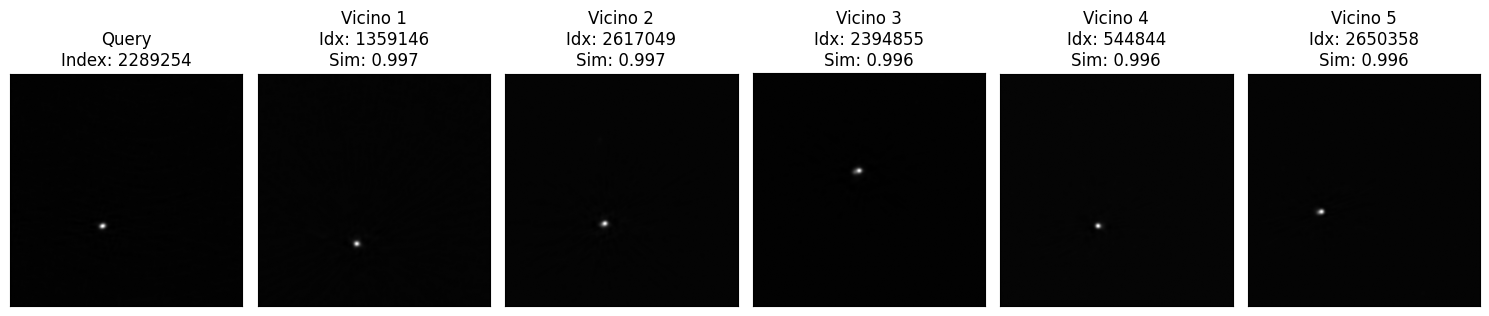

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import os
import random

# --- Configurazioni per la Cella di Test ---
FULL_FEATURES_NPY_PATH = '/leonardo_work/INA24_C5B09/radio-data-curation-ssl/outputs/features/features-model_vit_small_patch14_reg4_dinov2lvd142m-variant__64effbed/features.npy' # <<< MODIFICA: Path delle features globali
FULL_METADATA_JSON_PATH = '/leonardo_work/INA24_C5B09/radio-data-curation-ssl/outputs/cutouts/cutouts-strategy_sliding_window-overlap_05-size_256_30d67552/info.json' # <<< MODIFICA: Path JSON originale
NUM_NEIGHBORS = 5

# Assicurati che IMAGE_BASE_DIR sia disponibile (dalla cella principale o ridefiniscilo qui)
if 'IMAGE_BASE_DIR' not in globals():
    IMAGE_BASE_DIR = '/leonardo_work/INA24_C5B09/radio-data-curation-ssl' # <<< MODIFICA se necessario
    print(f"WARN: IMAGE_BASE_DIR non trovato globalmente, usando: {IMAGE_BASE_DIR}")

print("--- Test Ricerca Vicini (Dataset Globale) ---")

# --- Verifica Immagine Corrente ---
if 'current_image_data' not in globals() or not current_image_data:
    print("ERRORE: Nessuna immagine corrente selezionata nell'annotatore.")
    print("Esegui la cella principale e visualizza almeno un'immagine.")
else:
    query_image_data = current_image_data # Usa l'immagine attualmente visualizzata
    query_file_path = query_image_data.get('file_path')
    print(f"Immagine Query (dall'annotatore): {query_file_path}")

    try:
        # --- Caricamento Dati Globali ---
        print(f"Caricamento features globali da: {FULL_FEATURES_NPY_PATH}")
        full_features = np.load(FULL_FEATURES_NPY_PATH)
        print(f"  Caricate {full_features.shape[0]} features di dimensione {full_features.shape[1]}")

        print(f"Caricamento metadati globali da: {FULL_METADATA_JSON_PATH}")
        # Ricarica il DataFrame completo per sicurezza (o usa metadata_df_full se ancora disponibile)
        metadata_df_full = pd.read_json(FULL_METADATA_JSON_PATH, orient='index')
        # Crea mappa file_path -> indice nel dataset globale
        full_filepath_to_index = {fp: i for i, fp in enumerate(metadata_df_full['file_path'])}
        # Crea lista metadati globali per accesso facile
        full_metadata_list = metadata_df_full.to_dict(orient='records')
        print(f"  Caricati {len(full_metadata_list)} record metadati globali.")

        # Verifica coerenza
        if full_features.shape[0] != len(full_metadata_list):
            raise ValueError(f"Discrepanza tra numero features ({full_features.shape[0]}) e metadati ({len(full_metadata_list)})!")

        # --- Trova Indice Query nel Dataset Globale ---
        if query_file_path not in full_filepath_to_index:
             raise ValueError(f"File path query '{query_file_path}' non trovato nei metadati globali!")
        query_index_full = full_filepath_to_index[query_file_path]
        print(f"Indice query nel dataset globale: {query_index_full}")

        # --- Calcolo Similarità ---
        query_vector = full_features[query_index_full].reshape(1, -1) # Prendi il vettore e rendilo 2D
        print("Calcolo similarità coseno...")
        similarities = cosine_similarity(query_vector, full_features)[0] # [0] per ottenere array 1D
        print(f"  Calcolate {len(similarities)} similarità.")

        # --- Trova Indici Vicini ---
        # Argsort in ordine decrescente (più simile -> prima)
        sorted_indices = np.argsort(similarities)[::-1]

        # Prendi i primi N+1 (includerà la query stessa al primo posto)
        # Escludi il primo indice (la query stessa)
        neighbor_indices_full = sorted_indices[1 : NUM_NEIGHBORS + 1]
        neighbor_similarities = similarities[neighbor_indices_full]

        print(f"Indici dei {NUM_NEIGHBORS} vicini più simili nel dataset globale: {neighbor_indices_full}")
        print(f"Similarità corrispondenti: {neighbor_similarities}")

        # --- Recupera e Visualizza Risultati ---
        neighbor_metadata_list = [full_metadata_list[i] for i in neighbor_indices_full]

        # Setup plot
        fig, axes = plt.subplots(1, NUM_NEIGHBORS + 1, figsize=(15, 4)) # 1 riga, N+1 colonne

        # Visualizza Immagine Query
        ax_query = axes[0]
        try:
            query_full_path = os.path.join(IMAGE_BASE_DIR, query_file_path) if IMAGE_BASE_DIR and not os.path.isabs(query_file_path) else query_file_path
            if os.path.exists(query_full_path):
                img_query_array = np.load(query_full_path)
                ax_query.imshow(img_query_array, cmap='gray', origin='lower')
                ax_query.set_title(f"Query\nIndex: {query_index_full}")
            else:
                 ax_query.text(0.5, 0.5, 'Query\n(File non trovato)', ha='center', va='center', fontsize=8, color='red')
            ax_query.set_xticks([])
            ax_query.set_yticks([])
        except Exception as e:
            ax_query.text(0.5, 0.5, f'Query\nErrore: {e}', ha='center', va='center', fontsize=8, color='red')
            print(f"Errore caricamento immagine query: {e}")

        # Visualizza Vicini
        for i, neighbor_idx in enumerate(neighbor_indices_full):
            ax_neighbor = axes[i + 1]
            neighbor_data = neighbor_metadata_list[i]
            neighbor_file_path = neighbor_data.get('file_path')
            sim_score = neighbor_similarities[i]

            try:
                if neighbor_file_path:
                    neighbor_full_path = os.path.join(IMAGE_BASE_DIR, neighbor_file_path) if IMAGE_BASE_DIR and not os.path.isabs(neighbor_file_path) else neighbor_file_path
                    if os.path.exists(neighbor_full_path):
                        img_neighbor_array = np.load(neighbor_full_path)
                        ax_neighbor.imshow(img_neighbor_array, cmap='gray', origin='lower')
                        ax_neighbor.set_title(f"Vicino {i+1}\nIdx: {neighbor_idx}\nSim: {sim_score:.3f}")
                    else:
                        ax_neighbor.text(0.5, 0.5, f'Vicino {i+1}\n(File non trovato)', ha='center', va='center', fontsize=8, color='red')
                else:
                     ax_neighbor.text(0.5, 0.5, f'Vicino {i+1}\n(No file_path)', ha='center', va='center', fontsize=8, color='red')

            except Exception as e:
                ax_neighbor.text(0.5, 0.5, f'Vicino {i+1}\nErrore: {e}', ha='center', va='center', fontsize=8, color='red')
                print(f"Errore caricamento vicino {i+1} (indice {neighbor_idx}): {e}")

            ax_neighbor.set_xticks([])
            ax_neighbor.set_yticks([])

        plt.tight_layout()
        plt.show()

    except FileNotFoundError as e:
        print(f"ERRORE File non trovato: {e}")
        print("Verifica i path FULL_FEATURES_NPY_PATH e FULL_METADATA_JSON_PATH.")
    except ValueError as e:
        print(f"ERRORE di Valore/Coerenza: {e}")
    except Exception as e:
        print(f"ERRORE Inatteso: {e}")
        traceback.print_exc() # Stampa il traceback completo per errori inattesi

--- Ricerca Vicini per Immagine Corrente (Log Scale) ---
Query: outputs/cutouts/cutouts-strategy_sliding_window-overlap_05-size_256_30d67552/P236+35/npy/patch_3968_9088.npy (Indice Globale: 949163)
Indici Vicini Globali: [1880287 2293690 2634627   44816 1279506]
Similarità: [0.99997646 0.9999721  0.9999713  0.99997085 0.9999698 ]


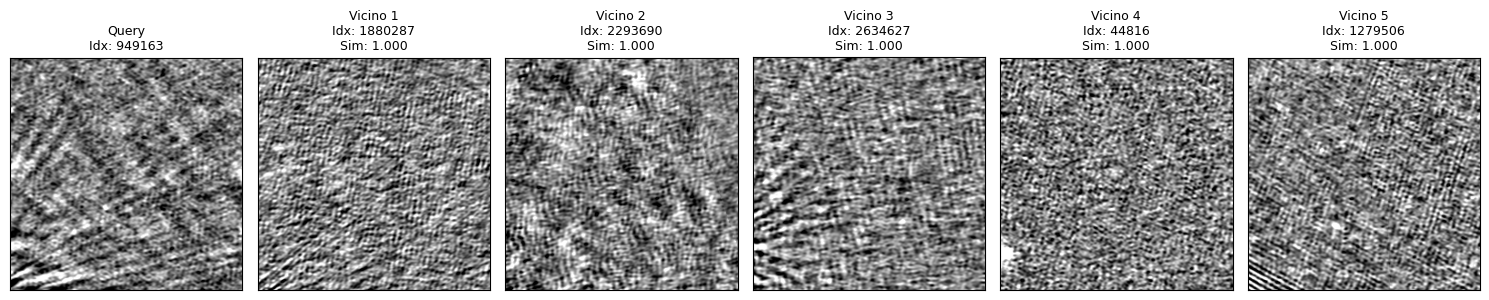

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import os
import traceback

# --- Configurazione Minima ---
NUM_NEIGHBORS = 5

print("--- Ricerca Vicini per Immagine Corrente (Log Scale) ---")

# --- Verifica Disponibilità Dati Globali ---
required_globals = ['current_image_data', 'full_features', 'full_metadata_list', 'full_filepath_to_index', 'IMAGE_BASE_DIR']
missing_globals = [g for g in required_globals if g not in globals() or globals()[g] is None or (isinstance(globals()[g], (list, dict, set)) and not globals()[g])]

if missing_globals:
    print(f"ERRORE: Variabili globali necessarie mancanti o vuote: {missing_globals}")
    print("Assicurati di aver eseguito la cella principale dell'annotatore e che abbia caricato i dati globali.")
else:
    try:
        # --- Ottieni Info Query ---
        query_data = current_image_data # Riferimento all'immagine nell'annotatore
        query_file_path = query_data.get('file_path')
        if not query_file_path:
            print("ERRORE: Immagine corrente nell'annotatore non ha 'file_path'.")
        elif query_file_path not in full_filepath_to_index:
             print(f"ERRORE: File path query '{query_file_path}' non trovato nella mappa globale.")
        else:
            query_index_full = full_filepath_to_index[query_file_path]
            print(f"Query: {query_file_path} (Indice Globale: {query_index_full})")

            # --- Calcola Similarità (leggero) ---
            query_vector = full_features[query_index_full].reshape(1, -1)
            similarities = cosine_similarity(query_vector, full_features)[0]

            # --- Trova Vicini ---
            sorted_indices = np.argsort(similarities)[::-1]
            neighbor_indices_full = sorted_indices[1 : NUM_NEIGHBORS + 1]
            neighbor_similarities = similarities[neighbor_indices_full]

            print(f"Indici Vicini Globali: {neighbor_indices_full}")
            print(f"Similarità: {neighbor_similarities}")

            # --- Visualizzazione (con Log Scale) ---
            fig, axes = plt.subplots(1, NUM_NEIGHBORS + 1, figsize=(15, 4))

            # Helper per visualizzare immagine in log scale
            def display_log_image(ax, img_path, title):
                 try:
                     full_img_path = os.path.join(IMAGE_BASE_DIR, img_path) if IMAGE_BASE_DIR and not os.path.isabs(img_path) else img_path
                     if os.path.exists(full_img_path):
                         img_array = np.load(full_img_path).astype(np.float32) # Converti a float per log
                         # Applica log1p (log(1+x)) per gestire zeri
                         img_log = np.log1p(img_array)
                         # Gestisci inf/nan che potrebbero risultare
                         img_log = np.nan_to_num(img_log, nan=np.nanmin(img_log), posinf=np.nanmax(img_log), neginf=np.nanmin(img_log))
                         # Calcola limiti sui dati log-trasformati
                         vmin, vmax = np.nanpercentile(img_log, [1, 99])
                         if vmin == vmax: # Immagine costante
                             vmin -= 0.1
                             vmax += 0.1
                         ax.imshow(img_log, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
                         ax.set_title(title, fontsize=9)
                     else:
                         ax.text(0.5, 0.5, f'{title}\n(File non trovato)', ha='center', va='center', fontsize=8, color='red')
                 except Exception as e:
                     ax.text(0.5, 0.5, f'{title}\nErrore: {e}', ha='center', va='center', fontsize=8, color='red')
                     print(f"Errore visualizzazione {img_path}: {e}")
                 finally:
                     ax.set_xticks([])
                     ax.set_yticks([])

            # Visualizza Query
            display_log_image(axes[0], query_file_path, f"Query\nIdx: {query_index_full}")

            # Visualizza Vicini
            for i, neighbor_idx in enumerate(neighbor_indices_full):
                 neighbor_data = full_metadata_list[neighbor_idx]
                 neighbor_file_path = neighbor_data.get('file_path')
                 sim_score = neighbor_similarities[i]
                 display_log_image(axes[i+1], neighbor_file_path, f"Vicino {i+1}\nIdx: {neighbor_idx}\nSim: {sim_score:.3f}")

            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"ERRORE durante l'esecuzione della cella vicini: {e}")
        traceback.print_exc()

--- Test Ricerca Vicini per 3 Query Casuali (Dataset Globale, Log Scale) ---
Utilizzo features e metadati globali già caricati.

Indici query casuali selezionati: [2553578, 593016, 1706653]

--- Elaborazione Query 1/3 (Indice Globale: 2553578) ---
  File query: outputs/cutouts/cutouts-strategy_sliding_window-overlap_05-size_256_30d67552/P207+32/npy/patch_6400_3072.npy
  Vicini trovati (Indici Globali): [1781756 1614305  774991  287591 1591929]


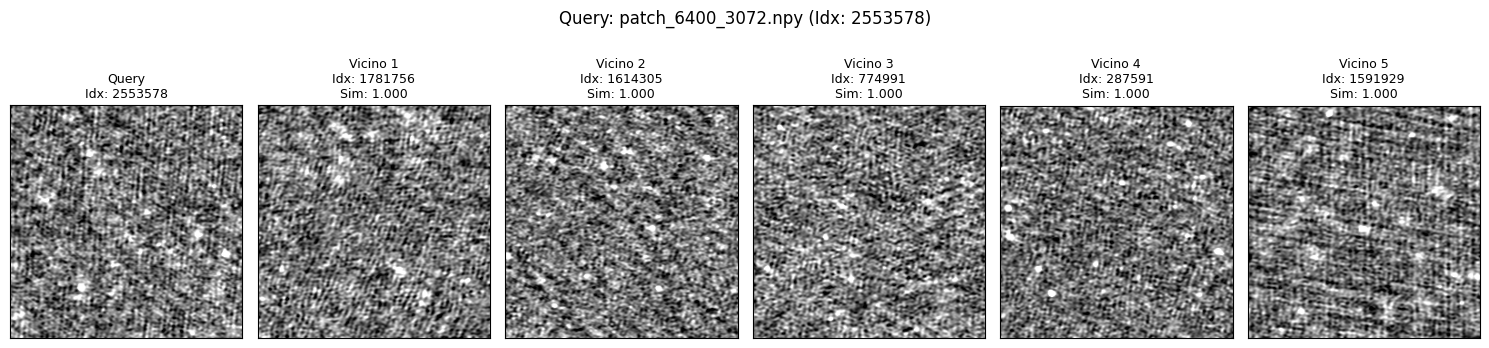

--------------------------------
--- Elaborazione Query 2/3 (Indice Globale: 593016) ---
  File query: outputs/cutouts/cutouts-strategy_sliding_window-overlap_05-size_256_30d67552/P163+45/npy/patch_3456_8192.npy
  Vicini trovati (Indici Globali): [2048315 1700494 2734774 2186417 2730663]


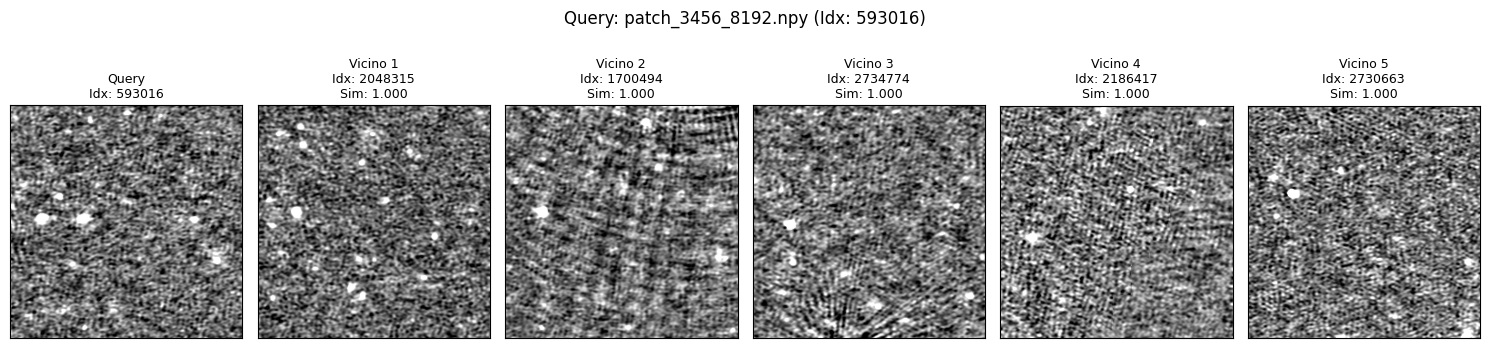

--------------------------------
--- Elaborazione Query 3/3 (Indice Globale: 1706653) ---
  File query: outputs/cutouts/cutouts-strategy_sliding_window-overlap_05-size_256_30d67552/P038+41/npy/patch_1792_2944.npy
  Vicini trovati (Indici Globali): [2975379  216148  748858  755188 2936888]


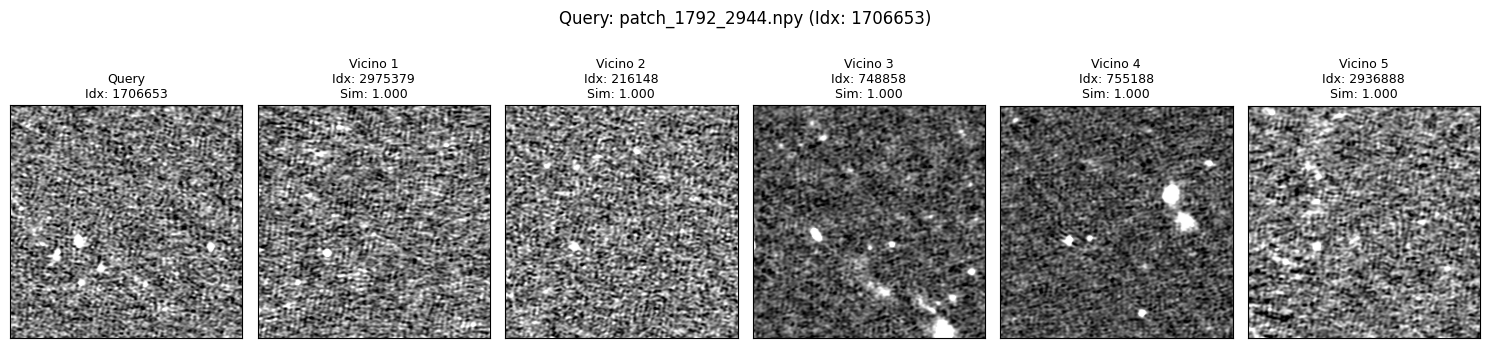

--------------------------------


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import os
import random
import traceback

# --- Configurazioni per Questa Cella ---
NUM_RANDOM_QUERIES = 10 # Quante immagini query casuali testare
NUM_NEIGHBORS = 5    # Quanti vicini mostrare per ogni query

print(f"--- Test Ricerca Vicini per {NUM_RANDOM_QUERIES} Query Casuali (Dataset Globale, Log Scale) ---")

# Helper per visualizzare immagine in log scale (copiato/adattato dalla cella precedente)
def display_log_image(ax, img_path, title):
     img_array = None # Inizializza per gestione errori
     try:
         full_img_path = os.path.join(IMAGE_BASE_DIR, img_path) if IMAGE_BASE_DIR and not os.path.isabs(img_path) else img_path
         if os.path.exists(full_img_path):
             img_array = np.load(full_img_path).astype(np.float32) # Converti a float per log
             # Applica log1p (log(1+x)) per gestire zeri
             img_log = np.log1p(img_array)
             # Gestisci inf/nan che potrebbero risultare
             valid_log_values = img_log[np.isfinite(img_log)] # Trova valori finiti per min/max
             min_log_val = np.min(valid_log_values) if valid_log_values.size > 0 else 0
             max_log_val = np.max(valid_log_values) if valid_log_values.size > 0 else 1
             img_log = np.nan_to_num(img_log, nan=min_log_val, posinf=max_log_val, neginf=min_log_val)
             # Calcola limiti sui dati log-trasformati
             vmin, vmax = np.percentile(img_log, [1, 99]) # Usa percentili sull'immagine log
             if vmin == vmax: # Immagine costante
                 vmin -= 0.1
                 vmax += 0.1
                 # Applica lo scaling dello slider all'ampiezza
                 scaling_factor = 10**(-(-1.)) # Slider > 0 -> riduce range -> aumenta contrasto
                 half_width_new = half_width_orig * scaling_factor

                 vmin = center - half_width_new
                 vmax = center + half_width_new
             ax.imshow(img_log, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
             ax.set_title(title, fontsize=9)
         else:
             ax.text(0.5, 0.5, f'{title}\n(File non trovato)', ha='center', va='center', fontsize=8, color='red')
     except Exception as e:
         error_msg = f'{title}\nErrore: {e}'
         if img_array is not None: error_msg += f'\nShape:{img_array.shape}' # Aggiunge info utili
         ax.text(0.5, 0.5, error_msg , ha='center', va='center', fontsize=8, color='red')
         print(f"Errore visualizzazione {img_path}: {e}")
     finally:
         ax.set_xticks([])
         ax.set_yticks([])


# --- Caricamento Dati Globali (o riutilizzo se già presenti) ---
loaded_successfully = False
try:
    # Controlla se le variabili globali esistono e sono valide
    if 'full_features' in globals() and 'full_metadata_list' in globals() and \
       globals()['full_features'] is not None and globals()['full_metadata_list']:
        print("Utilizzo features e metadati globali già caricati.")
        full_features = globals()['full_features']
        full_metadata_list = globals()['full_metadata_list']
        # Assicurati che la mappa esista o creala
        if 'full_filepath_to_index' not in globals() or not globals()['full_filepath_to_index']:
             print("Creazione mappa globale file path -> indice...")
             globals()['full_filepath_to_index'] = {item['file_path']: i for i, item in enumerate(full_metadata_list)}
        full_filepath_to_index = globals()['full_filepath_to_index']
        if full_features.shape[0] != len(full_metadata_list):
             print("ATTENZIONE: Dati globali caricati non consistenti. Provo a ricaricare.")
             raise ValueError("Dati globali inconsistenti.") # Forza ricaricamento
        loaded_successfully = True
    else:
        print("Variabili globali non trovate o non valide. Caricamento da file...")
        if not os.path.exists(FULL_FEATURES_NPY_PATH): raise FileNotFoundError(f"File features non trovato: {FULL_FEATURES_NPY_PATH}")
        if not os.path.exists(FULL_METADATA_JSON_PATH): raise FileNotFoundError(f"File metadati non trovato: {FULL_METADATA_JSON_PATH}")

        full_features = np.load(FULL_FEATURES_NPY_PATH)
        metadata_df_full = pd.read_json(FULL_METADATA_JSON_PATH, orient='index')
        full_metadata_list = metadata_df_full.to_dict(orient='records')
        print(f"  Caricate {full_features.shape[0]} features e {len(full_metadata_list)} metadati.")
        if full_features.shape[0] != len(full_metadata_list):
            raise ValueError(f"Discrepanza features ({full_features.shape[0]}) / metadati ({len(full_metadata_list)})!")
        print("Creazione mappa globale file path -> indice...")
        full_filepath_to_index = {item['file_path']: i for i, item in enumerate(full_metadata_list)}
        # Opzionale: Salva globalmente per futuro riutilizzo
        globals()['full_features'] = full_features
        globals()['full_metadata_list'] = full_metadata_list
        globals()['full_filepath_to_index'] = full_filepath_to_index
        loaded_successfully = True

except FileNotFoundError as e:
    print(f"ERRORE Critico - File non trovato: {e}")
except ValueError as e:
    print(f"ERRORE Critico - Discrepanza Dati: {e}")
except Exception as e:
    print(f"ERRORE Critico - Caricamento Dati Fallito: {e}")
    traceback.print_exc()

# --- Procedi solo se i dati sono stati caricati ---
if loaded_successfully:
    try:
        num_total_images = len(full_metadata_list)
        if num_total_images == 0:
             print("ERRORE: Nessun metadato globale caricato.")
        elif NUM_RANDOM_QUERIES > num_total_images:
             print(f"ATTENZIONE: Richieste {NUM_RANDOM_QUERIES} query, ma solo {num_total_images} immagini disponibili. Ne uso {num_total_images}.")
             NUM_RANDOM_QUERIES = num_total_images

        # --- Seleziona Indici Query Casuali ---
        random_indices = random.sample(range(num_total_images), NUM_RANDOM_QUERIES)
        print(f"\nIndici query casuali selezionati: {random_indices}\n")

        # --- Itera sulle Query Casuali ---
        for query_idx, query_index_full in enumerate(random_indices):
            print(f"--- Elaborazione Query {query_idx + 1}/{NUM_RANDOM_QUERIES} (Indice Globale: {query_index_full}) ---")
            query_data = full_metadata_list[query_index_full]
            query_file_path = query_data.get('file_path', 'N/D')
            print(f"  File query: {query_file_path}")

            # --- Calcolo Similarità e Vicini ---
            query_vector = full_features[query_index_full].reshape(1, -1)
            similarities = cosine_similarity(query_vector, full_features)[0]
            sorted_indices = np.argsort(similarities)[::-1]
            neighbor_indices_full = sorted_indices[1 : NUM_NEIGHBORS + 1]
            neighbor_similarities = similarities[neighbor_indices_full]

            # --- Visualizzazione ---
            fig, axes = plt.subplots(1, NUM_NEIGHBORS + 1, figsize=(15, 4))
            fig.suptitle(f"Query: {os.path.basename(query_file_path)} (Idx: {query_index_full})", fontsize=12)

            # Visualizza Query
            display_log_image(axes[0], query_file_path, f"Query\nIdx: {query_index_full}")

            # Visualizza Vicini
            print(f"  Vicini trovati (Indici Globali): {neighbor_indices_full}")
            for i, neighbor_idx in enumerate(neighbor_indices_full):
                 neighbor_data = full_metadata_list[neighbor_idx]
                 neighbor_file_path = neighbor_data.get('file_path')
                 sim_score = neighbor_similarities[i]
                 display_log_image(axes[i+1], neighbor_file_path, f"Vicino {i+1}\nIdx: {neighbor_idx}\nSim: {sim_score:.3f}")

            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Aggiusta layout per suptitle
            plt.show()
            # plt.close(fig) # Opzionale: chiude la figura dopo averla mostrata

            print("-" * (len(f"--- Elaborazione Query {query_idx + 1}/{NUM_RANDOM_QUERIES} ---") + 2)) # Separatore

    except Exception as e:
        print(f"\nERRORE durante l'elaborazione delle query: {e}")
        traceback.print_exc()
else:
    print("\nImpossibile procedere a causa di errori nel caricamento dei dati.")